In [ ]:
# Import a bunch
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Input, BatchNormalization, LSTM
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from sklearn.model_selection import train_test_split
import math
import pandas as pd
import matplotlib
import matplotlib.image as mpimg
import seaborn as sns
import os
from glob import glob
import shutil
import pathlib
import json

In [ ]:
!wget https://github.com/musikalkemist/DeepLearningForAudioWithPython/raw/master/11-%20Preprocessing%20audio%20data%20for%20deep%20learning/code/blues.00000.wav

--2020-10-12 08:09:23--  https://github.com/musikalkemist/DeepLearningForAudioWithPython/raw/master/11-%20Preprocessing%20audio%20data%20for%20deep%20learning/code/blues.00000.wav
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/musikalkemist/DeepLearningForAudioWithPython/master/11-%20Preprocessing%20audio%20data%20for%20deep%20learning/code/blues.00000.wav [following]
--2020-10-12 08:09:24--  https://raw.githubusercontent.com/musikalkemist/DeepLearningForAudioWithPython/master/11-%20Preprocessing%20audio%20data%20for%20deep%20learning/code/blues.00000.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [ ]:
file = '/content/blues.00000.wav'

In [ ]:
signal, sr = librosa.load(file, sr=22050)
#signal = numpy array => sr*T(sample rate * duration) -> 22050 * 30 values (amplitude of the waves form)

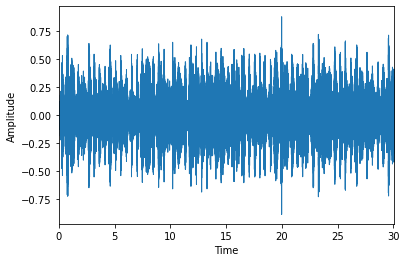

In [ ]:
librosa.display.waveplot(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
# FFT to transform from time domain to frequency domain
fft = np.fft.fft(signal)

# Perform absolute values from complex values => indicate the contribution of each frequency to the sound
magnitude = np.abs(fft)
# Get number of evenly spaced number in an interval
frequency = np.linspace(0, sr, len(magnitude)) 

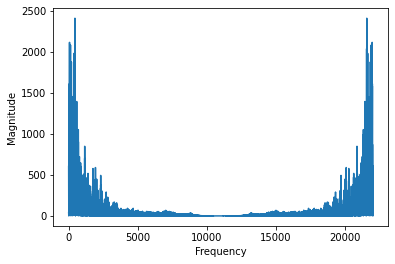

In [ ]:
# Powerspectrum
plt.plot(frequency, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

Most of the energy focus on the beginning and the end of the file.
The plot is symmetrical. The point of the symmetry is the middle point of plot.

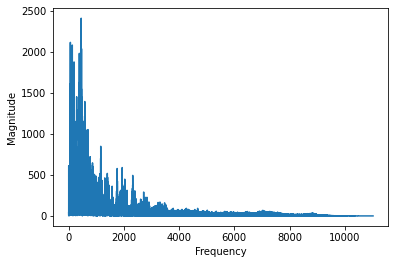

In [ ]:
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

The problem with powerspectrum:

*   It is a static snapshot of the whole sound. How each frequency contributing to the whole sound.



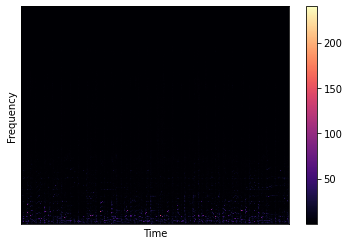

In [ ]:
# STFT:
# Number of sample
n_fft = 2048

# Hop length: the amount the window shifting to the right => the speed of sliding to the right
hop_length = 512

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft) #Complex number
spectrogram = np.abs(stft)

librosa.display.specshow(spectrogram)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

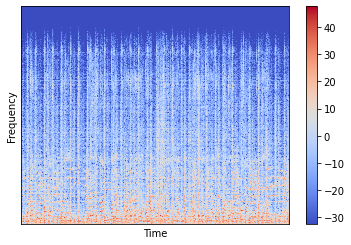

In [ ]:
#Calculate log spectrogram
log_spectrogram = librosa.amplitude_to_db(spectrogram)
librosa.display.specshow(log_spectrogram)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

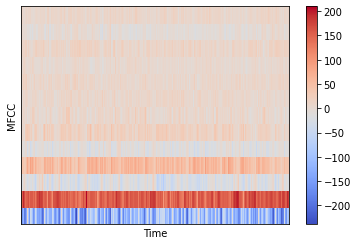

In [ ]:
# MFCCs
MFCCs = librosa.feature.mfcc(signal, n_fft, hop_length=hop_length, n_mfcc=13)
librosa.display.specshow(MFCCs)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

In [ ]:
!wget http://opihi.cs.uvic.ca/sound/genres.tar.gz

In [ ]:
# Install kaggle
! pip install -q kaggle
#Upload json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"datnguyn","key":"69c14f649dd7364914db7810156aeea6"}'}

In [ ]:
#Download dataset
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

 99% 1.20G/1.21G [00:17<00:00, 81.5MB/s]
100% 1.21G/1.21G [00:17<00:00, 73.7MB/s]


In [ ]:
!unzip /content/gtzan-dataset-music-genre-classification.zip  && rm /content/gtzan-dataset-music-genre-classification.zip

Archive:  /content/gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues

In [ ]:
DATASET_PATH = '/content/Data/genres_original'
JSON_PATH = '/content/data.json'
SAMPLE_RATE = 22050
DURATION = 30 # duration of each audio file is 30s
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [ ]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
  #Saving the data into different segments

  #dictionary to store data
  data = {
      "mapping": [],
      "mfcc": [],
      "labels": []
  }
  num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
  expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length) # Round to the higher number
  # MFCC as the input data => expect the labels 1, 2, 3... => mapping labels to the specific genre in genre list
  count = 0
  count_error = 0

  ### Lopp through all the genre and analyse the song one by one ###
  # os.walk: current directory + directory names + file names
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
    try: 
    #ensure we're not at the root level

      if dirpath is not dataset_path:
        # save the semantic label
        dirpath_components = dirpath.split('/')
        semantic_label = dirpath_components[-1]
        data['mapping'].append(semantic_label)
        print('Processing {}'.format(semantic_label))
  
        # Process file for specific genre
        for f in filenames:
        
          file_path = os.path.join(dirpath, f)
          signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
          count +=1
  
          # Process segments extracting mfcc and storing data
          for s in range(num_segments):
            start_sample = num_samples_per_segment * s # s=0 -> start at 0
            finish_sample = start_sample + num_samples_per_segment # finish at the num_sample_per_segment
  
            
            mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                        sr=sr,
                                        n_mfcc=n_mfcc, 
                                        n_fft=n_fft, 
                                        hop_length=hop_length)
            mfcc = mfcc.T # get the transpose
            # Store mfcc for segment if it has the expected length 
            if len(mfcc) == expected_num_mfcc_vectors_per_segment:
              data['mfcc'].append(mfcc.tolist())
              data['labels'].append(i-1)
              print('{}, segment:{}'.format(file_path, s))
            #Loop through all the folders of each genre and count the folders.# 
            #For the first iteration, it loops through the dataset path and then start count the folder with genre from 1 => need to be (i-1)#
            
    except:
      count_error += 1
      pass          
  with open(JSON_PATH, "w") as fp:
    json.dump(data, fp, indent=4)
  print(str(count_error))
  print(str(count))

In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=5)

Processing country
/content/Data/genres_original/country/country.00055.wav, segment:0
/content/Data/genres_original/country/country.00055.wav, segment:1
/content/Data/genres_original/country/country.00055.wav, segment:2
/content/Data/genres_original/country/country.00055.wav, segment:3
/content/Data/genres_original/country/country.00055.wav, segment:4
/content/Data/genres_original/country/country.00020.wav, segment:0
/content/Data/genres_original/country/country.00020.wav, segment:1
/content/Data/genres_original/country/country.00020.wav, segment:2
/content/Data/genres_original/country/country.00020.wav, segment:3
/content/Data/genres_original/country/country.00020.wav, segment:4
/content/Data/genres_original/country/country.00079.wav, segment:0
/content/Data/genres_original/country/country.00079.wav, segment:1
/content/Data/genres_original/country/country.00079.wav, segment:2
/content/Data/genres_original/country/country.00079.wav, segment:3
/content/Data/genres_original/country/count

In [ ]:
# Multiclass classification
# Load data
def load_data(json_path):
  with open(json_path, "r") as fp: # opening for reading
    data = json.load(fp)

  # convert list into numpy arrays
  inputs = np.array(data['mfcc'])
  targets = np.array(data['labels'])

  return inputs, targets


In [ ]:
# Get the function
inputs, targets = load_data(JSON_PATH)

In [ ]:
inputs.shape

(4883, 259, 13)

In [ ]:
# Split data into train and test
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs,
                                                                          targets,
                                                                          test_size=0.2)

In [ ]:
# Build network architecture and Compile network
BATCH_SIZE = 32
model = keras.Sequential([
                          # input layers
                          # MFCC for each track 
                          # => Have many MFCC vectors, each represent a single segment/intervel of the track, depending on the hop_length
                          # 1st: number of intervals
                          # 2nd: the number of MFCC vectors
                          Flatten(input_shape=(inputs.shape[1], inputs.shape[2])),
                          Dense(512, activation='relu'),
                          Dense(256, activation='relu'),
                          Dense(64, activation='relu'),
                          Dense(10, activation='softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3367)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1724416   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 1,872,842
Trainable params: 1,872,842
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Checkpoint
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath='mymodel_{epoch}.h5',
        save_best_only = True,
        verbose=1)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience =20,restore_best_weights=True)

In [ ]:
#Train network
history = model.fit(inputs_train, targets_train,
          validation_data=(inputs_test, targets_test),
          epochs=500,
          batch_size=BATCH_SIZE,
          callbacks=[checkpoint_cb,early_stopping_cb])

In [ ]:
# Create train, validation and test sets
X, y = load_data(JSON_PATH)
# create the train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# create the train/validation split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)


In [ ]:
# 3d array input -> (130, 13, 1)
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]
#give an extra axis => 4D array -> (numple_samples, 130, 13, 1)

In [ ]:
# Build CNN model
def build_model(input_shape):
  #create model
  model = keras.Sequential()

  #1st CNN layer
  model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same"))
  model.add(BatchNormalization())
  #2nd CNN layer
  model.add(Conv2D(32, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same"))
  model.add(BatchNormalization())
  #3rd CNN layer
  model.add(Conv2D(32, (2,2), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))
  model.add(BatchNormalization())
  #Flatten and fit into dense layers
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.3))
  #output layers
  model.add(Dense(10, activation='softmax'))
  
  return model

In [ ]:
a = input_shape

In [ ]:
# Buil the CNN network
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_model(input_shape=input_shape)
model.summary()

In [ ]:
# Compile the network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 257, 11, 32)       320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 129, 6, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 129, 6, 32)        128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 127, 4, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 2, 32)         0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 2, 32)         128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 63, 1, 32)       

In [ ]:
# Train the CNN
history = model.fit(X_train, y_train,
          validation_data=(X_validation, y_validation),
          epochs=20,
          batch_size=BATCH_SIZE,
          callbacks=[checkpoint_cb,early_stopping_cb])

In [ ]:
# Evaluate CNN on the test set
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy on test set is: {}".format(test_accuracy))

In [ ]:
def predict(X, y):
  X = X[np.newaxis, ...]
  # prediction is 2D array [[0.1, 0.2, ...]] => 10 value of different scores of 10 different genres
  prediction = tf.keras.models.load_model('/content/mymodel_20.h5').predict(X) # X -> 2D array
  #extract index with max value
  predicted_index = np.argmax(prediction, axis=1)
  print("Expected output is {}, Predicted index {}".format(y, predicted_index))

In [ ]:
# Make prediction on a sample
X = X_test[100]
y = y_test[100]

predict(X, y)

Expected output is 8, Predicted index [8]


In [ ]:
y_test[100]

8

**RNN and LSTM**

In [ ]:
#Prepare datasets for RNN & LSTM
def prepare_datasets(test_size, validation_size):
    # load data
    X, y = load_data(JSON_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [ ]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.2, 0.2)

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])

In [ ]:
# Build CNN model
def build_model(input_shape):
  #create model
  model = keras.Sequential()
  # 2 LSTM layers
  model.add(LSTM(64, input_shape=input_shape, return_sequences=True)) #sequence to sequence
  #passing the sequence to the next lstm layer
  model.add(LSTM(64))
  #Dense layer
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.3))
  #output layers
  model.add(Dense(10, activation='softmax'))
  
  return model

In [ ]:
model = build_model(input_shape)

In [ ]:
# Compile the network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 259, 64)           19968     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the CNN
history = model.fit(X_train, y_train,
          validation_data=(X_validation, y_validation),
          epochs=20,
          batch_size=BATCH_SIZE,
          callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/20
98/98 [==============================] - ETA: 0s - loss: 2.2560 - accuracy: 0.1588
Epoch 00001: val_loss did not improve from 1.09620
98/98 [==============================] - 3s 28ms/step - loss: 2.2560 - accuracy: 0.1588 - val_loss: 2.2005 - val_accuracy: 0.2596
Epoch 2/20
97/98 [============================>.] - ETA: 0s - loss: 2.1341 - accuracy: 0.2661
Epoch 00002: val_loss did not improve from 1.09620
98/98 [==============================] - 2s 21ms/step - loss: 2.1338 - accuracy: 0.2666 - val_loss: 2.0656 - val_accuracy: 0.3043
Epoch 3/20
97/98 [============================>.] - ETA: 0s - loss: 1.9983 - accuracy: 0.3212
Epoch 00003: val_loss did not improve from 1.09620
98/98 [==============================] - 2s 21ms/step - loss: 1.9977 - accuracy: 0.3217 - val_loss: 1.9191 - val_accuracy: 0.3274
Epoch 4/20
97/98 [============================>.] - ETA: 0s - loss: 1.8790 - accuracy: 0.3428
Epoch 00004: val_loss did not improve from 1.09620
98/98 [=======================

In [ ]:
def predict(X, y):
  X = X[np.newaxis, ...]
  # prediction is 2D array [[0.1, 0.2, ...]] => 10 value of different scores of 10 different genres
  prediction = tf.keras.models.load_model('/content/mymodel_20.h5').predict(X) # X -> 2D array
  #extract index with max value
  predicted_index = np.argmax(prediction, axis=1)
  print("Expected output is {}, Predicted index {}".format(y, predicted_index))